# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I import all the required libraries

In [1]:
#import the necessary libraries
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

## Next I calibrate the camera and create a undistort wrapper.

In [2]:
# Calibrate Camera & Undistort Image
def calibrate_camera():

    # Load all names of pictures
    images = glob.glob('camera_cal/calibration*.jpg')

    # Variables for Chess Board:
    corners_x = 9
    corners_y = 6
    # Set up Arrays for Imagepoints and Objectpoints
    img_pts = [] #2-D Picture Points
    obj_pts = [] #3-D Real World Point

    #Create the base for the object points
    obj_p = np.zeros((corners_y * corners_x, 3), np.float32)
    obj_p[:,:2] = np.mgrid[0:corners_x, 0:corners_y].T.reshape(-1,2)

    for image in images:
        # Read in the image
        img = cv2.imread(image)

        # Convert to Gray Scale
        gray_chess = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find corners of Chess Board
        ret, corners = cv2.findChessboardCorners(gray_chess, (corners_x, corners_y), None)

        # Add detected corners and image points to the defined arrays
        if ret == True:
            img_pts.append(corners)
            obj_pts.append(obj_p)

            # Draw and corners on image
            cv2.drawChessboardCorners(img, (corners_x, corners_y), corners, ret)
    
    # Get the Matrix and distortian coefficients and return them.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray_chess.shape[::-1], None, None)
    return (mtx, dist)

# Undistort the image
## I devided it, so that not with every undistortian the camera needs to be calibrated.

def undistort_image(img, mtx, dist):
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    return dst_img

---
## Third, I create my functions for the color space transform and for the gradients

In [3]:
# binary S-Space output

def hls_Sspace(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    S_img = hls_img[:,:,2]
    # Return a binary image of threshold result
    S_bin = np.zeros_like(S_img)
    S_bin[(S_img > thresh[0]) & (S_img <= thresh[1])] = 1
    sSpace_binary_output = np.copy(S_bin) # placeholder line
    
    return sSpace_binary_output

In [4]:
# Sobel Functions

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    ## only take the one required to improve performance
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,1,0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,0,1, ksize=sobel_kernel)
    else:
        print("Error: Wrong Orientation") #To be changed to Error Handler
        
    # Get the absolute value of the sobel
    sobel_dir_abs = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_dir_abs/np.max(sobel_dir_abs))
    # Create a binary mask 
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make 1's where the sobel is within the thresholds 
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return
    grad_binary = np.copy(sobel_binary)
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Get the gradient in x and y
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    # Calculate the magnitude 
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit and convert to uint8 type
    sobel_scaled = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Create a binary mask 
    sobel_mag_binary = np.zeros_like(sobel_scaled)
    # Make 1's where the sobel_mag is within the thresholds 
    sobel_mag_binary[(sobel_scaled >= mag_thresh[0]) & (sobel_scaled <= mag_thresh[1])] = 1
    
    # Return
    mag_binary = sobel_mag_binary
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Get the gradient in x and y
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    # Get the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    # Get the direction of the gradient 
    grad = np.arctan2(sobely_abs, sobelx_abs)
    # Create a binary
    sobel_binary = np.zeros_like(gray_img)
    # Make 1's where the sobel_dir is within the thresholds 
    sobel_binary[(grad >= thresh[0]) & (thresh[1] >= grad)] = 1
    
    # Return
    dir_binary = sobel_binary
    return dir_binary

---
## Next, I create functions for "Region of Interest" and "Curve Messurement"

In [5]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

---
## Next, I create functions for Finding the Lane Pixels, Calculating the Polynome and Curve Messurement

In [6]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom quater of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 72
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Update the boundaries of the window
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Get second order polynomial for the found coordinates
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #print(binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fitx` and `right_fitx` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ## 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #window_img = np.zeros_like(out_img)
    #print(leftx.shape)
    #print(rightx.shape)
    #print(ploty.shape)
    #left_line = np.array([np.transpose(np.vstack([leftx, ploty]))])
    #right_line = np.array([np.transpose(np.vstack([rightx, ploty]))])
    #line_pts = np.hstack((left_line, right_line))
    
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    #cv2.fillPoly(out_img, np.int_([line_pts]), (0,255, 0))
    
    return out_img, left_fit, right_fit, ploty, leftx, rightx

def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, xm, ym):
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/800 # meters per pixel in x dimension
      
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve
    left_curverad = (((1+(2*left_fit_cr[0]*y_eval*ym + left_fit_cr[1])**2)**(3/2)) / np.abs(2* left_fit_cr[0]))
    right_curverad = (((1+(2*right_fit_cr[0]*y_eval*ym + right_fit_cr[1])**2)**(3/2)) / np.abs(2* right_fit_cr[0]))
    
    return left_curverad, right_curverad

---
## This is the parameter sheet to tune the parameters

In [7]:
# Parameters to be tuned:
## Image Size
im_test = cv2.imread('test_images/test1.jpg')
img_size = (im_test.shape[1], im_test.shape[0])
## For the Image Transformation
### Source Points of the image
### Assumption that the camera is in the middle of the car
src = np.float32(
        [[(img_size[0]//2)-500, img_size[1]],
        [((img_size[0]//2)-100), 480],
        [((img_size[0]//2)+100), 480],
        [(img_size[0]//2)+500, img_size[1]]])

### Destination Points of the image
dst = np.float32(
        [[200,img_size[1]],
        [200, 0],
        [img_size[0]-200, 0],
        [img_size[0]-200, img_size[1]]])

## Area of Interest
### Region for the lane marking area:
region = np.array([[(180,img_size[1]),(580,450), (720,450), (1200,img_size[1])]], dtype=np.int)

## Parameters to hand to Hough Transformation ###
#rho = 1;
#theta = 2*(np.pi / 180)
#threshold = 30
#min_line_len = 80
#max_line_gap = 80

## Parametes for Sobel
sX_kernel = 31
sY_kernel = 31
sMag_kernel = 27
sDir_kernel = 31
sX_thresh = (70, 255)
sY_thresh = (70, 255)
sMag_thresh = (100, 255)
sDir_thresh = (0.85, 1.05)
hls_thresh = (100, 255)

## Parameters for real world transfrom
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/800 # meters per pixel in x dimension




---
## From here starts the main Logic

Text(0.5,1,'Destination Image')

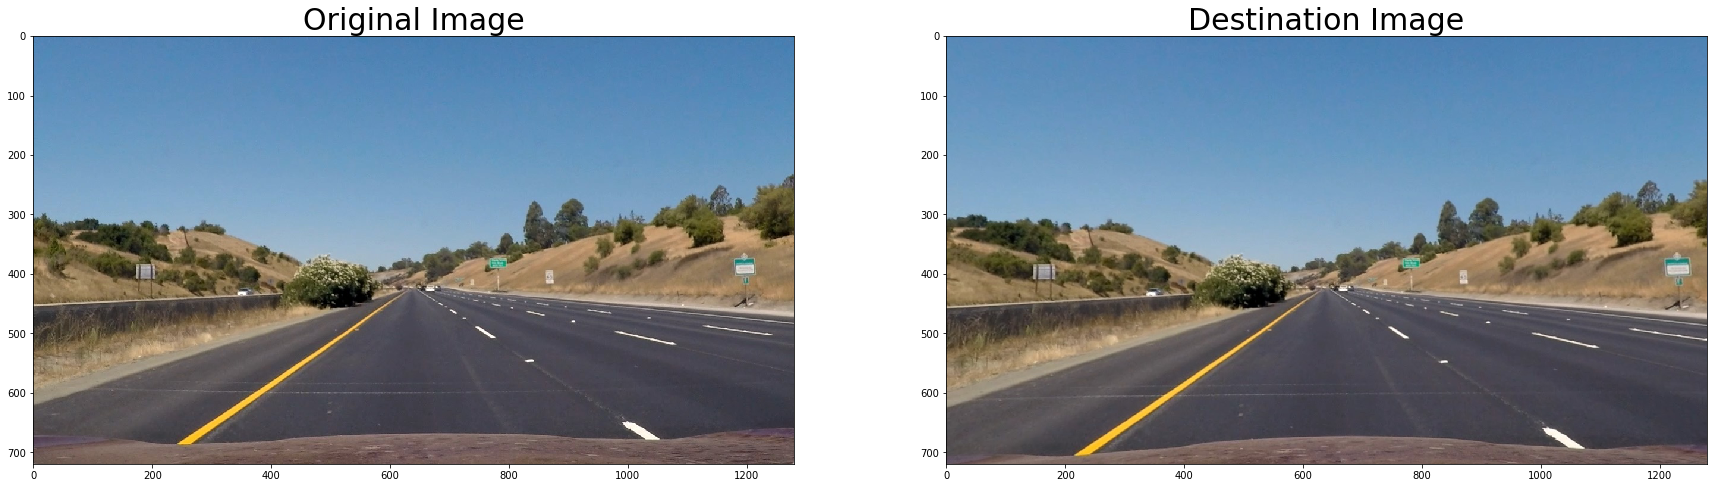

In [8]:
# main Logic 
## calibrate Camera:
mtx_camera, dist_camera = calibrate_camera()

## Get Image and Undistrot Image
img = cv2.imread('test_images/straight_lines1.jpg')
img_undist = undistort_image(img, mtx_camera, dist_camera)

# Plot the Original and Destination image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img[...,::-1])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist[...,::-1], cmap='gray')
ax2.set_title('Destination Image', fontsize=30)

Text(0.5,1,'Binary Image')

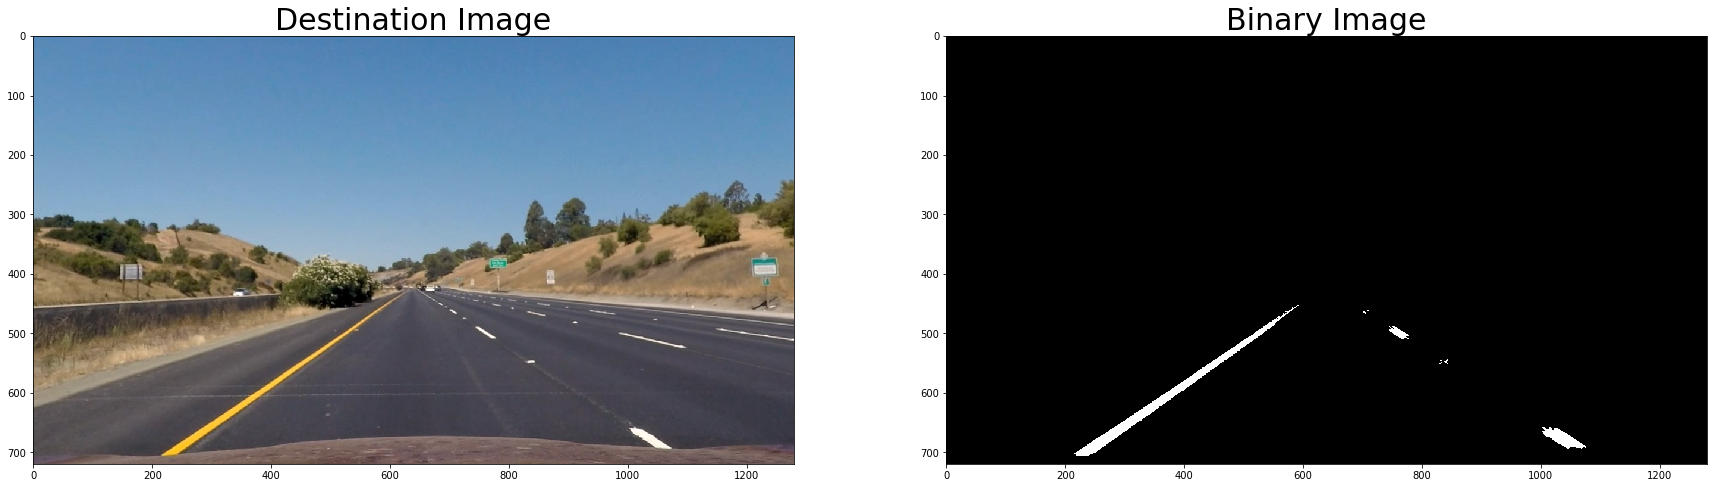

In [9]:
## Create a binary Image
result_x = abs_sobel_thresh(img_undist, 'x', sX_kernel, sX_thresh) 
result_y = abs_sobel_thresh(img_undist, 'y', sY_kernel, sY_thresh)
result_mag = mag_thresh(img_undist, sMag_kernel, sMag_thresh)
result_dir = dir_threshold(img_undist, sDir_kernel, sDir_thresh)
result_hls = hls_Sspace(img_undist, hls_thresh)

combined = np.zeros_like(result_x)
combined[((result_x == 1) & (result_y == 1)) | (((result_mag == 1) & (result_dir == 1))) | (result_hls == 1)] = 1
combined_img = region_of_interest(combined, region)

# Plot the destination and binary image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img_undist[...,::-1])
ax1.set_title('Destination Image', fontsize=30)
ax2.imshow(combined_img, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

Text(0.5,1,'Output Image')

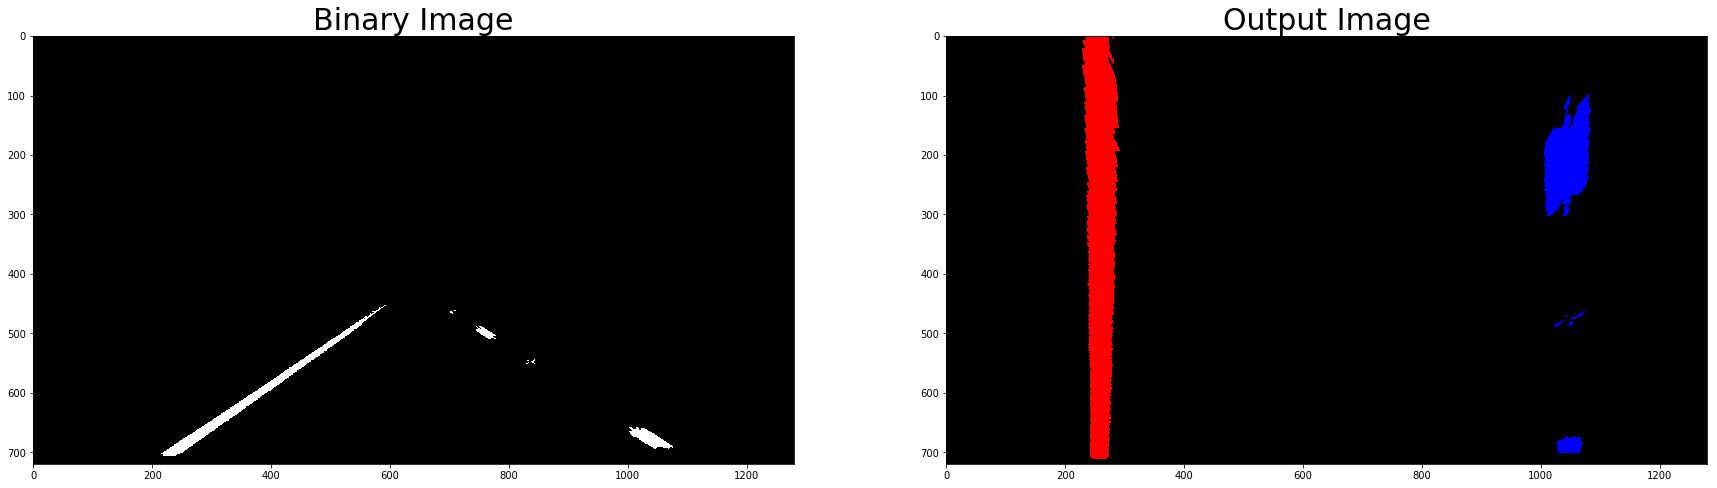

In [10]:
### Create Image Size Parameters for warpPerspective
img_size = (img.shape[1], img.shape[0])

mtx_persp = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combined_img, mtx_persp, img_size, flags=cv2.INTER_LINEAR)

## Detect the Lines in the warped Image
### Get the Polynomiyal for the left and right side
### also get the amount of pixels detected to use later as a weighting.
### The more pixles detected the higher the accuracy.
out_img, left_poly, right_poly, poly, leftx, rightx = fit_polynomial(warped)

# Plot the destination and binary image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(combined_img, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(out_img, cmap='gray')
ax2.set_title('Output Image', fontsize=30)

Text(0.5,1,'Result Image')

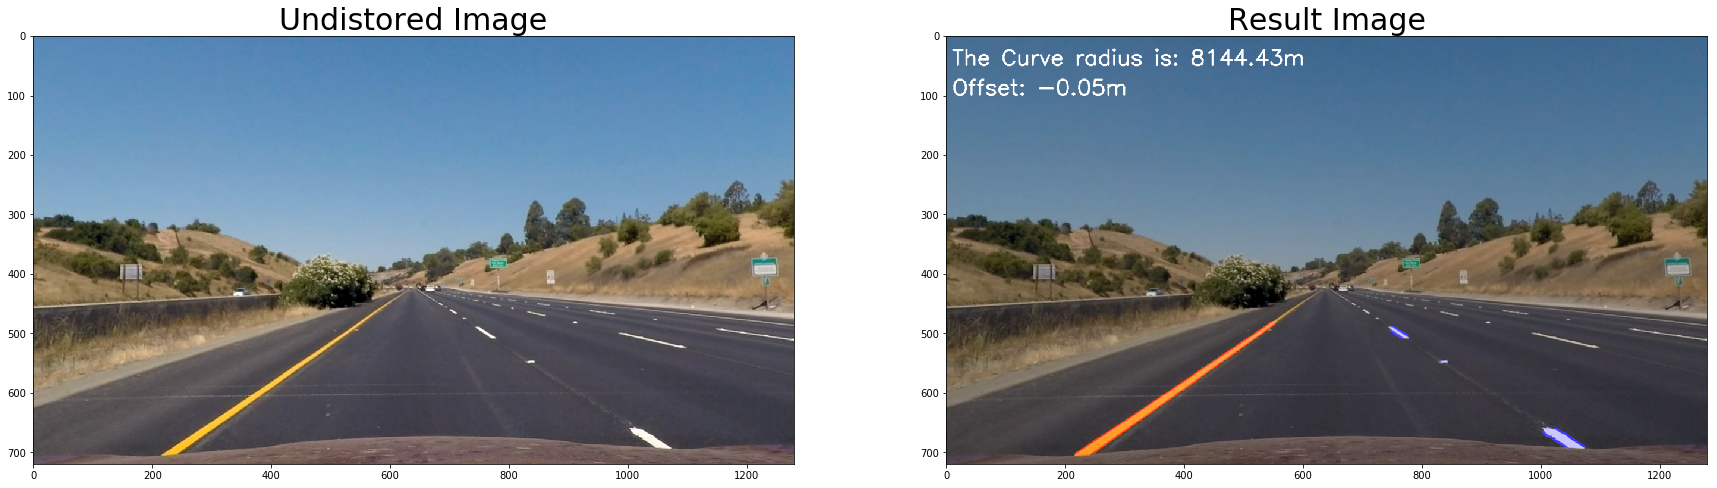

In [11]:
## Getting Curvature for left and right side
left_r, right_r = measure_curvature_real(poly, left_poly, right_poly, xm_per_pix, ym_per_pix)

## Weight the curvature ratios based on the amount of pixles
weighted_r = (((left_r * leftx.shape[0]) + (right_r * rightx.shape[0])) / (((leftx.shape[0] + rightx.shape[0]))))
weighted_r = math.trunc(weighted_r * 100) / 100
radius_str = "The Curve radius is: " + str(weighted_r) + 'm'
#cv2.putText(img,radius_str,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),4)

## Get the position and offset in the lane
position = (np.average(leftx) + np.average(rightx)) / 2
offset = ((img_size[0]/2)-position)*xm_per_pix
offset = math.trunc(offset * 100) / 100
offset_str = "Offset: " + str(offset) + 'm'
#cv2.putText(img,offset_str,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),4)

## Print the lines back into the image:
font = cv2.FONT_HERSHEY_SIMPLEX
mtx_persp_inv = cv2.getPerspectiveTransform(dst, src)
lines_img = cv2.warpPerspective(out_img, mtx_persp_inv, img_size, flags=cv2.INTER_LINEAR)
output_img = cv2.addWeighted(img_undist[...,::-1], .8, lines_img, 0.9, 0.2)
cv2.putText(output_img,radius_str,(10,50), font, 1.2,(255,255,255),2, cv2.LINE_AA)
cv2.putText(output_img,offset_str,(10,100), font, 1.2,(255,255,255),2, cv2.LINE_AA)
###!!!! fill the area between the center green

# Plot the destination and binary image.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img_undist[...,::-1])
ax1.set_title('Undistored Image', fontsize=30)
ax2.imshow(output_img)
ax2.set_title('Result Image', fontsize=30)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):  
    ## Get Image and Undistrot Image
    #img = np.copy(image) 
    img_undist = undistort_image(image, mtx_camera, dist_camera)

    ## Create a binary Image
    result_x = abs_sobel_thresh(img_undist, 'x', sX_kernel, sX_thresh) 
    result_y = abs_sobel_thresh(img_undist, 'y', sY_kernel, sY_thresh)
    result_mag = mag_thresh(img_undist, sMag_kernel, sMag_thresh)
    result_dir = dir_threshold(img_undist, sDir_kernel, sDir_thresh)
    result_hls = hls_Sspace(img_undist, hls_thresh)

    combined = np.zeros_like(result_x)
    combined[((result_x == 1) & (result_y == 1)) | (((result_mag == 1) & (result_dir == 1))) | (result_hls == 1)] = 1
    combined_img = region_of_interest(combined, region)

    ### Create Image Size Parameters for warpPerspective
    img_size = (img_undist.shape[1], img_undist.shape[0])

    mtx_persp = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_img, mtx_persp, img_size, flags=cv2.INTER_LINEAR)

    ## Detect the Lines in the warped Image
    ### Get the Polynomiyal for the left and right side
    ### also get the amount of pixels detected to use later as a weighting.
    ### The more pixles detected the higher the accuracy.
    out_img, left_poly, right_poly, poly, leftx, rightx = fit_polynomial(warped)

    ## Getting Curvature for left and right side
    left_r, right_r = measure_curvature_real(poly, left_poly, right_poly, xm_per_pix, ym_per_pix)

    ## Weight the curvature ratios based on the amount of pixles
    weighted_r = (((left_r * leftx.shape[0]) + (right_r * rightx.shape[0])) / (((leftx.shape[0] + rightx.shape[0]))))
    weighted_r = math.trunc(weighted_r * 100) / 100
    radius_str = "The Curve radius is: " + str(weighted_r) + 'm'

    ## Get the position and offset in the lane
    position = (np.average(leftx) + np.average(rightx)) / 2
    offset = ((img_size[0]/2)-position)*xm_per_pix
    offset = math.trunc(offset * 100) / 100
    offset_str = "Offset: " + str(offset) + 'm'

    ## Print the lines back into the image:
    font = cv2.FONT_HERSHEY_SIMPLEX
    mtx_persp_inv = cv2.getPerspectiveTransform(dst, src)
    lines_img = cv2.warpPerspective(out_img, mtx_persp_inv, img_size, flags=cv2.INTER_LINEAR)
    output_img = cv2.addWeighted(img_undist[...,::-1], .8, lines_img, 0.9, 0.2)
    cv2.putText(output_img,radius_str,(10,50), font, 1.2,(255,255,255),2, cv2.LINE_AA)
    cv2.putText(output_img,offset_str,(10,100), font, 1.2,(255,255,255),2, cv2.LINE_AA)
    
    return output_img

In [13]:
mtx_camera, dist_camera = calibrate_camera()
white_output = 'project_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video.mp4
[MoviePy] Writing video project_video.mp4


 99%|█████████▉| 125/126 [01:05<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.mp4 

CPU times: user 57 s, sys: 5.14 s, total: 1min 2s
Wall time: 1min 6s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))